### Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Basic Processing

In [2]:
df = pd.read_csv('data/processed/1.1_initial_data_assessment_done.csv')
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,False,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,False,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,False,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,False,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,False,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,False,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,False,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,False,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,True,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Correlation Matrix for Numerical Columns

In [4]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [7]:
df_numeric = df.select_dtypes(include=[np.number])

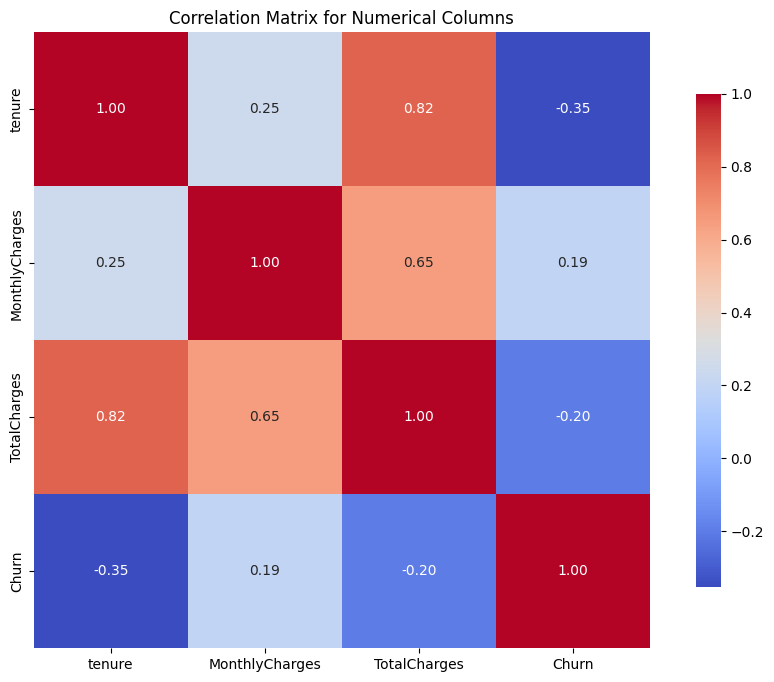

In [10]:
corr = df_numeric.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

There's a multi-collinearity issue as correlation between tenure and TotalCharges is 0.82

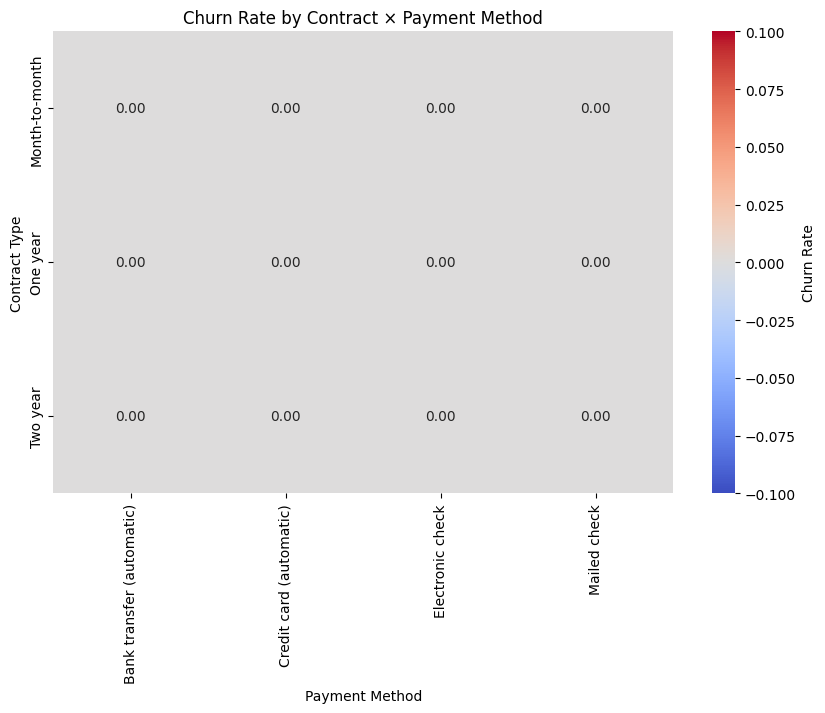

In [11]:
# Create cross-tab: Contract × PaymentMethod with churn rates
churn_rate = pd.crosstab(df["Contract"], df["PaymentMethod"], 
                         values=(df["Churn"] == "Yes").astype(int), 
                         aggfunc="mean")

# Plot as heatmap
plt.figure(figsize=(10,6))
sns.heatmap(churn_rate, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Churn Rate'})
plt.title("Churn Rate by Contract × Payment Method")
plt.ylabel("Contract Type")
plt.xlabel("Payment Method")
plt.show()

In [12]:
import pandas as pd

# Load dataset

# Rule-based segmentation
def segment_customer(row):
    if row["Contract"] == "Month-to-month" and row["PaymentMethod"] == "Electronic check":
        return "High Risk"
    elif row["Contract"] in ["One year", "Two year"] and "automatic" in row["PaymentMethod"]:
        return "Loyal"
    elif row["MonthlyCharges"] < 40:
        return "Minimalist"
    else:
        return "Other"

df["Segment"] = df.apply(segment_customer, axis=1)

# Calculate churn rate by segment
churn_rate = df.groupby("Segment")["Churn"].value_counts(normalize=True).unstack().fillna(0) * 100
print(churn_rate)


Churn               0          1
Segment                         
High Risk   46.270270  53.729730
Loyal       94.260600   5.739400
Minimalist  87.557182  12.442818
Other       71.006464  28.993536


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering (behavior + financial)
features = ["tenure", "MonthlyCharges",
            "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
            "TechSupport", "StreamingTV", "StreamingMovies"]

# Convert Yes/No to 1/0
for col in features[2:]:
    df[col] = df[col].map({"Yes":1, "No":0, "No internet service":0})

X = df[features]

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Calculate churn rate per cluster
churn_rate_clusters = df.groupby("Cluster")["Churn"].value_counts(normalize=True).unstack().fillna(0) * 100
print(churn_rate_clusters)

Churn            0          1
Cluster                      
0        85.509554  14.490446
1        71.144279  28.855721
2        70.637037  29.362963
